# Markovian VVIX Returns

This notebook will go over the use of an in-sample full-sample Markov Regression strategy to trade ```UX1``` and ```UX2``` spreads with lagged ```VIX``` and ```VVIX``` values. 

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\VIXCurveStrategies\root\src")
from MarkovianStrats import MarkovianStrats

## Lagged VVIX Model

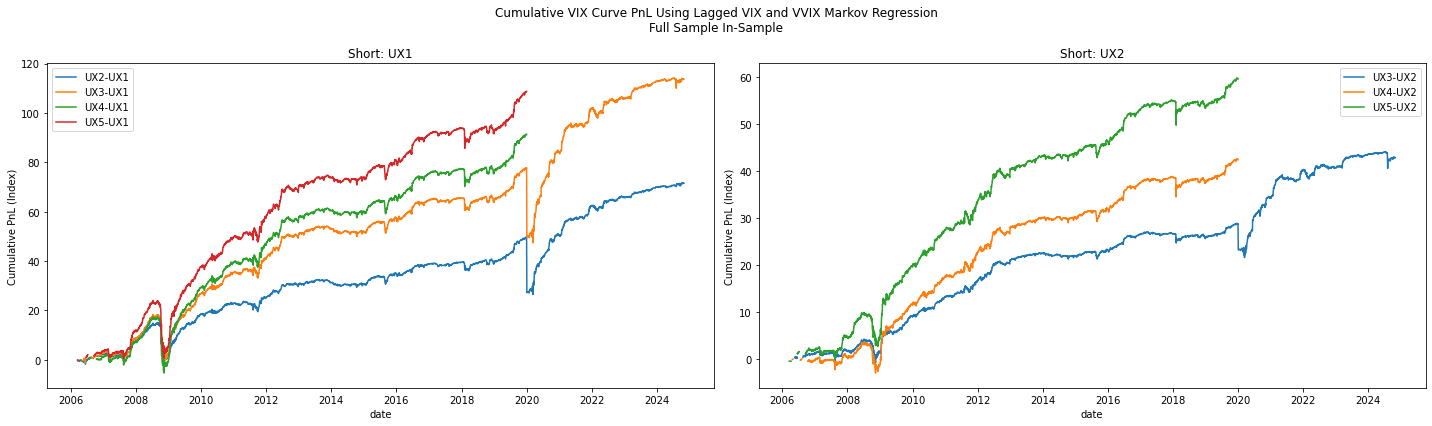

In [3]:
def plot_vvix_rtn() -> plt.Figure: 
    
    df_plot   = MarkovianStrats().generate_vvix_signal_rtn()
    legs      = df_plot.short_leg.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(legs), figsize = (20,6))

    for leg, ax in zip(legs, axes.flatten()): 

        (df_plot.query(
            "short_leg == @leg")
            [["date", "strat", "signal_spread"]].
            rename(columns = {"strat": ""}).
            pivot(index = "date", columns = "", values = "signal_spread").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumulative PnL (Index)",
                title  = "Short: " + leg))

    fig.suptitle("Cumulative VIX Curve PnL Using Lagged VIX and VVIX Markov Regression\nFull Sample In-Sample")
    plt.tight_layout()
    
plot_vvix_rtn()

In [4]:
def get_sharpe() -> pd.DataFrame: 
    
    df_sharpe = (MarkovianStrats().generate_vvix_signal_rtn()[
        ["strat", "signal_spread"]].
        groupby("strat").
        agg(["mean", "std"])
        ["signal_spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sharpe = get_sharpe()

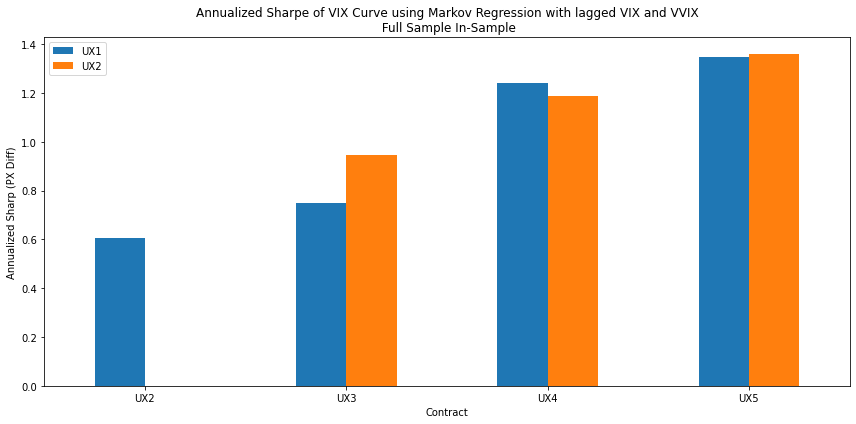

In [5]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_sharpe.assign(
        short_leg = lambda x: x.strat.str.split("-").str[0],
        long_leg  = lambda x: x.strat.str.split("-").str[1]).
        rename(columns = {"long_leg": ""}).
        pivot(index = "short_leg", columns = "", values = "sharpe").
        fillna(0).
        plot(
            kind    = "bar",
            xlabel  = "Contract",
            rot     = 0,
            ylabel  = "Annualized Sharp (PX Diff)",
            figsize = (12,6),
            title   = "Annualized Sharpe of VIX Curve using Markov Regression with lagged VIX and VVIX\n Full Sample In-Sample"))

    plt.tight_layout()
    
plot_sharpe(df_sharpe)

## Simple ERC Portfolio

In [18]:
def _get_erc(df: pd.DataFrame, window: int) -> pd.DataFrame:
    
    df_std = (df[
        ["date", "strat", "signal_spread"]].
        pivot(index = "date", columns = "strat", values = "signal_spread").
        ewm(span = window, adjust = False).
        std().
        shift().
        apply(lambda x: 1 / x).
        dropna().
        reset_index().
        melt(id_vars = "date").
        dropna())
    
    df_out = (df_std.drop(
        columns = ["strat"]).
        groupby("date").
        agg("sum").
        rename(columns = {"value": "cum_val"}).
        merge(right = df_std, how = "inner", on = ["date"]).
        assign(weight = lambda x: x.value / x.cum_val).
        dropna().
        merge(right = df, how = "inner", on = ["date", "strat"]).
        assign(weighted_rtn = lambda x: x.weight * x.signal_spread))
    
    return df_out

def get_erc(window: int = 30) -> pd.DataFrame: 

    df_out = (MarkovianStrats().generate_vvix_signal_rtn().groupby(
        "short_leg").
        apply(_get_erc, window).
        reset_index(drop = True))
    
    return df_out

df_erc = get_erc()

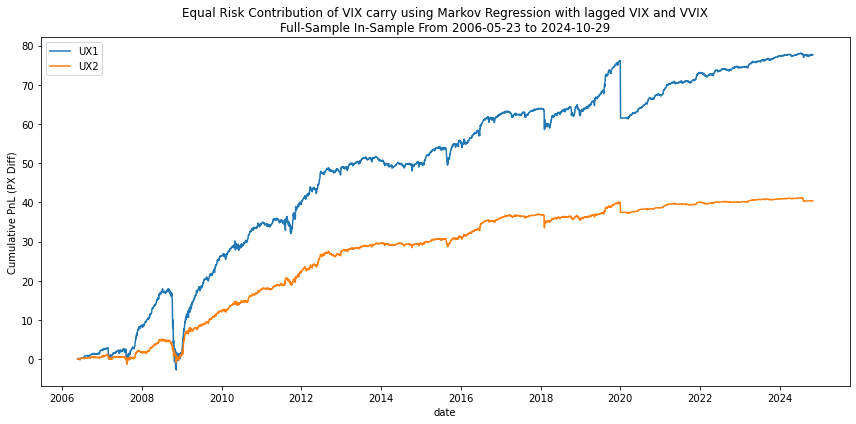

In [23]:
def plot_erc_perf(df_erc: pd.DataFrame) -> plt.Figure: 
    
    (df_erc[
        ["date", "weighted_rtn", "short_leg"]].
        groupby(["date", "short_leg"]).
        agg("sum").
        reset_index().
        rename(columns = {"short_leg": ""}).
        pivot(index = "date", columns = "", values = "weighted_rtn").
        cumsum().
        plot(
            figsize = (12, 6),
            ylabel  = "Cumulative PnL (PX Diff)",
            title   = "Equal Risk Contribution of VIX carry using Markov Regression with lagged VIX and VVIX\nFull-Sample In-Sample From {} to {}".format(
                df_erc.date.min(),
                df_erc.date.max())))
    
    plt.tight_layout()
    
plot_erc_perf(df_erc)

In [26]:
def get_erc_sharpe(df_erc: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_erc[
        ["date", "short_leg", "weighted_rtn"]].
        groupby(["date", "short_leg"]).
        agg("sum").
        reset_index().
        drop(columns = ["date"]).
        groupby("short_leg").
        agg(["mean", "std"])
        ["weighted_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_sharpe

df_sharpe = get_erc_sharpe(df_erc)

<AxesSubplot:xlabel='Contract', ylabel='Annualized Sharpe'>

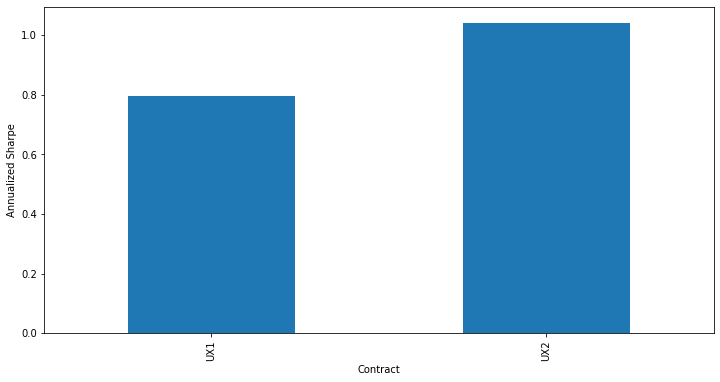

In [31]:
(df_sharpe[
    ["sharpe"]].
    plot(
        kind    = "bar",
        xlabel  = "Contract",
        ylabel  = "Annualized Sharpe",
        legend  = False,
        figsize = (12,6),
        rot     = 0,
        title   = "Annualized Sharpe of Equal Volatility Contribution "))